<a href="https://colab.research.google.com/github/Veeraj71/Brain_Tumor_Detection_System/blob/main/Brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Brain Tumor using Machine Learning
Uses Py libraries and based on concept of Classification

In [1]:
!unzip "/content/drive/MyDrive/Brain tumor/archive (2).zip" -d "/content/drive/MyDrive/Brain tumor"

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/Brain tumor/Training/glioma/Tr-gl_0712.jpg  
  inflating: /content/drive/MyDrive/Brain tumor/Training/glioma/Tr-gl_0713.jpg  
  inflating: /content/drive/MyDrive/Brain tumor/Training/glioma/Tr-gl_0714.jpg  
  inflating: /content/drive/MyDrive/Brain tumor/Training/glioma/Tr-gl_0715.jpg  
  inflating: /content/drive/MyDrive/Brain tumor/Training/glioma/Tr-gl_0716.jpg  
  inflating: /content/drive/MyDrive/Brain tumor/Training/glioma/Tr-gl_0717.jpg  
  inflating: /content/drive/MyDrive/Brain tumor/Training/glioma/Tr-gl_0718.jpg  
  inflating: /content/drive/MyDrive/Brain tumor/Training/glioma/Tr-gl_0719.jpg  
  inflating: /content/drive/MyDrive/Brain tumor/Training/glioma/Tr-gl_0720.jpg  
  inflating: /content/drive/MyDrive/Brain tumor/Training/glioma/Tr-gl_0721.jpg  
  inflating: /content/drive/MyDrive/Brain tumor/Training/glioma/Tr-gl_0722.jpg  
  inflating: /content/drive/MyDrive/Brain tumor/Training/g

## Approach:
1. Problem Definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1.Problem definition: Given MRI scan of a patient, can you predict they have a brain tumor or not?...If Yes, then what type of tumor?


## 2. Data
### About Dataset:
* Dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
* This dataset is a combination of the following three datasets :
figshare
SARTAJ dataset
Br35H

* This dataset contains 7023 images of human brain MRI images which are classified into 4 classes: glioma - meningioma - no tumor and pituitary.

* No tumor class images were taken from the Br35H dataset.

## Loading and Labeling Images with OpenCV

### Get our WOrkspace ready
* import TF 2.17
* import TF Hub
* Make sure you are using a GPU

In [2]:
# Import these libraries
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import glob
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
print("TF version:", tf.__version__)

TF version: 2.18.0


In [59]:
import random  # For generating random values for augmentation
from PIL import Image, ImageEnhance  # For image processing and enhancement
from tensorflow.keras.preprocessing.image import load_img  # For loading images
from tensorflow.keras.models import Sequential  # For building the model
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense  # For model layers
from tensorflow.keras.optimizers import Adam  # For optimizer
from tensorflow.keras.applications import VGG16  # For using VGG16 model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle  # For shuffling the data
import warnings
warnings.filterwarnings("ignore")


In [4]:
import tensorflow_hub as hub
print("TF Hub version:", hub.__version__)
# Check for GPU availability
print("GPU", "available (YESSSS!!!!!!!!)" if tf.config.list_physical_devices("GPU") else "not available :(")

TF Hub version: 0.16.1
GPU available (YESSSS!!!!!!!!)


In [5]:
# Lets see exactly how many images are we dealing with...
base_path = "/content/drive/MyDrive/Brain tumor/Training"
class_names = ["glioma", "meningioma", "pituitary", "notumor"]
# Count images in each class
class_counts = {class_name: len(os.listdir(os.path.join(base_path, class_name))) for class_name in class_names}
class_counts

{'glioma': 2642, 'meningioma': 2678, 'pituitary': 2914, 'notumor': 3190}

In [27]:
import os

# Base path to the main directory containing all the class folders
base_path = "/content/drive/MyDrive/Brain tumor/Training"

# Class prefixes for renaming
class_prefixes = {
    "glioma": "G",
    "meningioma": "M",
    "pituitary": "P",
    "notumor": "N"
}

for class_name, prefix in class_prefixes.items():
    class_path = os.path.join(base_path, class_name)
    files = os.listdir(class_path)

    # Extract numeric parts safely, default to 0 if none found
    files = sorted(files, key=lambda x: int(''.join(filter(str.isdigit, x))) if any(c.isdigit() for c in x) else 0)

    # Rename the files sequentially from 1 onwards
    for idx, file_name in enumerate(files, start=1):
        old_file_path = os.path.join(class_path, file_name)

        # Extract the file extension (e.g., .jpg, .png) to maintain format
        ext = os.path.splitext(file_name)[1]
        new_file_name = f"{prefix}{idx}{ext}"
        new_file_path = os.path.join(class_path, new_file_name)

        os.rename(old_file_path, new_file_path)

print("✅ Files renamed sequentially for all classes in Training set!")


✅ Files renamed sequentially for all classes in Training set!


In [7]:
# Directories for training and testing data
train_dir = "/content/drive/MyDrive/Brain tumor/Training"
test_dir = "/content/drive/MyDrive/Brain tumor/Testing"

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in class_names:  # Using predefined class_names
    class_path = os.path.join(train_dir, label)
    for image in os.listdir(class_path):
        train_paths.append(os.path.join(class_path, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in class_names:
    class_path = os.path.join(test_dir, label)
    for image in os.listdir(class_path):
        test_paths.append(os.path.join(class_path, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)


In [8]:
# Lets rename all files in Testing data
# Base path for the Testing set
test_base_path = "/content/drive/MyDrive/Brain tumor/Testing"

for class_name, prefix in class_prefixes.items():
    class_path = os.path.join(test_base_path, class_name)
    files = os.listdir(class_path)
    # Sort files numerically by extracting numbers from filenames
    files.sort(key=lambda x: int(''.join(filter(str.isdigit, x)) or 0))
    # Rename the files in the folder
    for idx, file_name in enumerate(files, start=1):
        old_file_path = os.path.join(class_path, file_name)
        new_file_name = f"{prefix}{idx}.jpg"
        new_file_path = os.path.join(class_path, new_file_name)
        os.rename(old_file_path, new_file_path)

print("Files renamed successfully for all classes in the Testing set!")


Files renamed successfully for all classes in the Testing set!


In [9]:
# Lets rename all files in Testing data
# Base path for the Testing set
test_base_path = "/content/drive/MyDrive/Brain tumor/Testing"

# Define class_prefixes here to make it available in this cell
class_prefixes = {
    "glioma": "G",
    "meningioma": "M",
    "pituitary": "P",
    "notumor": "N"
}

for class_name, prefix in class_prefixes.items():
    class_path = os.path.join(test_base_path, class_name)
    files = os.listdir(class_path)
    # Sort files numerically by extracting numbers from filenames
    files.sort(key=lambda x: int(''.join(filter(str.isdigit, x)) or 0))
    # Rename the files in the folder
    for idx, file_name in enumerate(files, start=1):
        old_file_path = os.path.join(class_path, file_name)
        new_file_name = f"{prefix}{idx}.jpg"
        new_file_path = os.path.join(class_path, new_file_name)
        os.rename(old_file_path, new_file_path)

print("Files renamed successfully for all classes in the Testing set!")

Files renamed successfully for all classes in the Testing set!


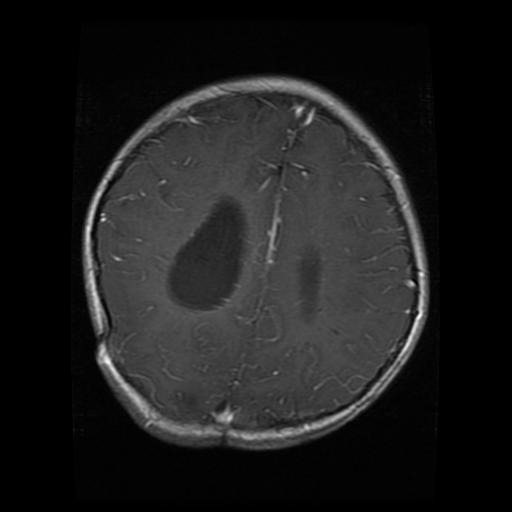

In [43]:
# Get a batch of test data
x_test, y_test = next(test_generator)

# Ensure the batch size is consistent
x_test = x_test[:batch_size]
y_test = y_test[:batch_size]

# Make predictions
predictions = model.predict(x_test)

# Convert probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Evaluation metrics
print("Accuracy:", accuracy_score(true_classes, predicted_classes))
print("Classification Report:")
print(classification_report(true_classes, predicted_classes))
print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))
# Lets test an image from testing data
from IPython.display import Image
Image("/content/drive/MyDrive/Brain tumor/Testing/glioma/G292.jpg")

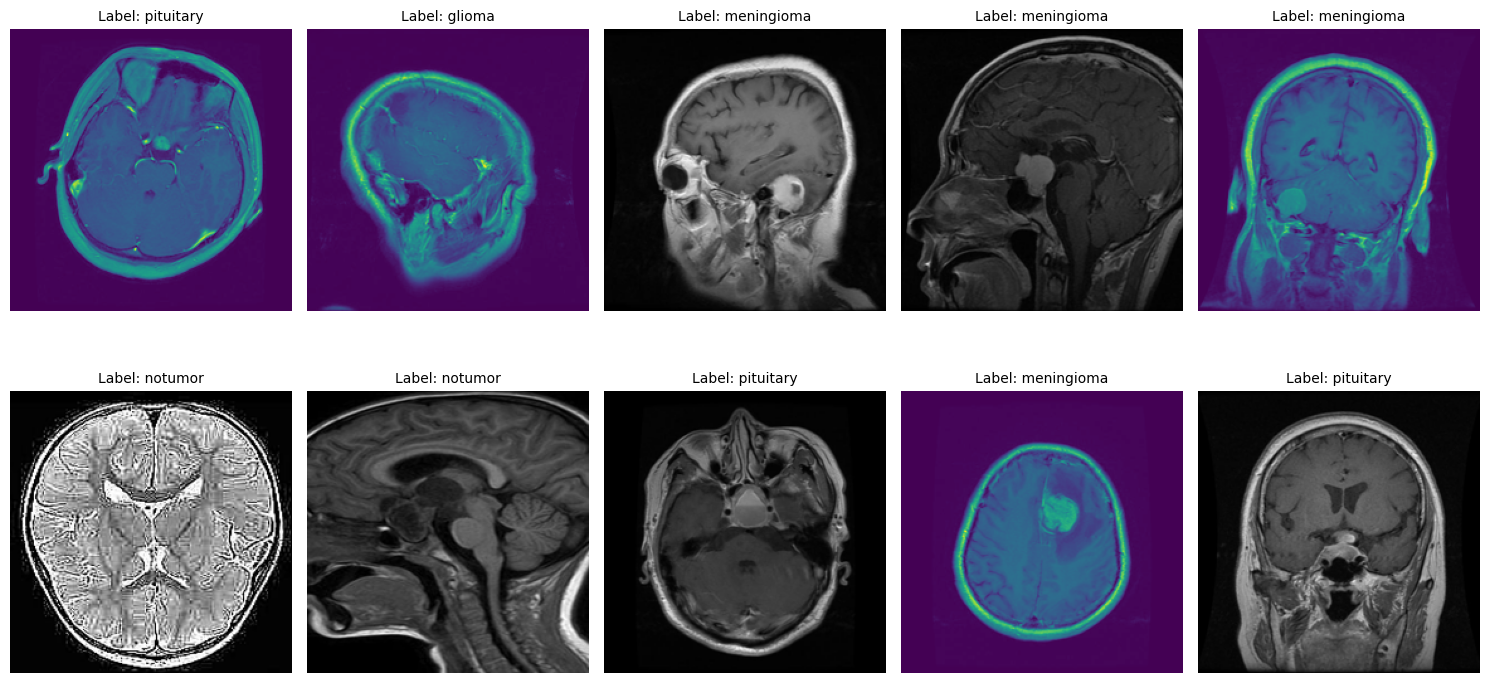

In [47]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Base path after renaming
base_path = "/content/drive/MyDrive/Brain tumor/Training"

# Class names
class_names = ["glioma", "meningioma", "pituitary", "notumor"]

# Collect updated image paths and labels
train_paths = []
train_labels = []

for class_name in class_names:
    class_folder = os.path.join(base_path, class_name)
    files = sorted(os.listdir(class_folder))  # Ensure correct order
    for file in files:
        train_paths.append(os.path.join(class_folder, file))
        train_labels.append(class_name)

# Select 10 random images without changing intended output
random_indices = random.sample(range(len(train_paths)), 10)

# Create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    img_path = train_paths[idx]  # Corrected path
    img = Image.open(img_path)
    img = img.resize((224, 224))  # Resize to consistent size

    # Display image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(f"Label: {train_labels[idx]}", fontsize=10)

plt.tight_layout()
plt.show()



# Data Exploration (exploratory data analysis or EDA)
### The goal here is to find out more about the data and become a subject matter export on the dataset you're working with.
1. What question(s) are you trying to solve?
2. at kind of data do we have and how do we treat different types?
3. Vhat's missing from the data and how do you deal with it?
4. Where are the outliers and why should you care about them?
5. How can you add, change or remove features to get more out of your data?

In [50]:
train_dir = "/content/drive/MyDrive/Brain tumor/Training"
test_dir = "/content/drive/MyDrive/Brain tumor/Testing"

train_count = sum(len(os.listdir(os.path.join(train_dir, c))) for c in os.listdir(train_dir))
test_count = sum(len(os.listdir(os.path.join(test_dir, c))) for c in os.listdir(test_dir))

total_images = train_count + test_count
print(f"Training: {train_count}, Testing: {test_count}, Total: {total_images}")


Training: 5712, Testing: 1311, Total: 7023


In [51]:
from collections import Counter
all_files =[]
for class_name in os.listdir(base_path):
  class_path = os.path.join(base_path, class_name)
  all_files.extend(os.listdir(class_path))
duplicates = [file for file, count in Counter(all_files).items() if count > 1]
print(f"Duplicate files: {duplicates}")

Duplicate files: []


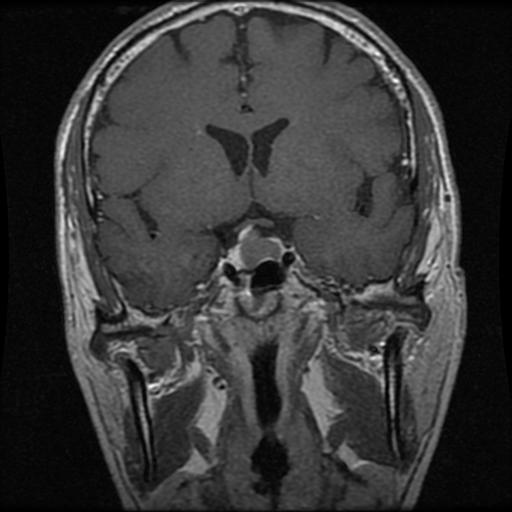

In [53]:
# Lets test an image
from IPython.display import Image
Image("/content/drive/MyDrive/Brain tumor/Training/pituitary/P1448.jpg")

In [54]:
class_names = ["glioma", "meningioma", "pituitary", "notumor"]
train_sizes = [
    len(os.listdir("/content/drive/MyDrive/Brain tumor/Training/glioma")),
    len(os.listdir("/content/drive/MyDrive/Brain tumor/Training/meningioma")),
    len(os.listdir("/content/drive/MyDrive/Brain tumor/Training/pituitary")),
    len(os.listdir("/content/drive/MyDrive/Brain tumor/Training/notumor"))
]
train_sizes

[1321, 1339, 1457, 1595]

In [55]:
test_sizes = [
    len(os.listdir("/content/drive/MyDrive/Brain tumor/Testing/glioma")),
    len(os.listdir("/content/drive/MyDrive/Brain tumor/Testing/meningioma")),
    len(os.listdir("/content/drive/MyDrive/Brain tumor/Testing/pituitary")),
    len(os.listdir("/content/drive/MyDrive/Brain tumor/Testing/notumor"))
]
test_sizes

[300, 306, 300, 405]

In [56]:
train_dir = "/content/drive/MyDrive/Brain tumor/Training"
test_dir = "/content/drive/MyDrive/Brain tumor/Testing"

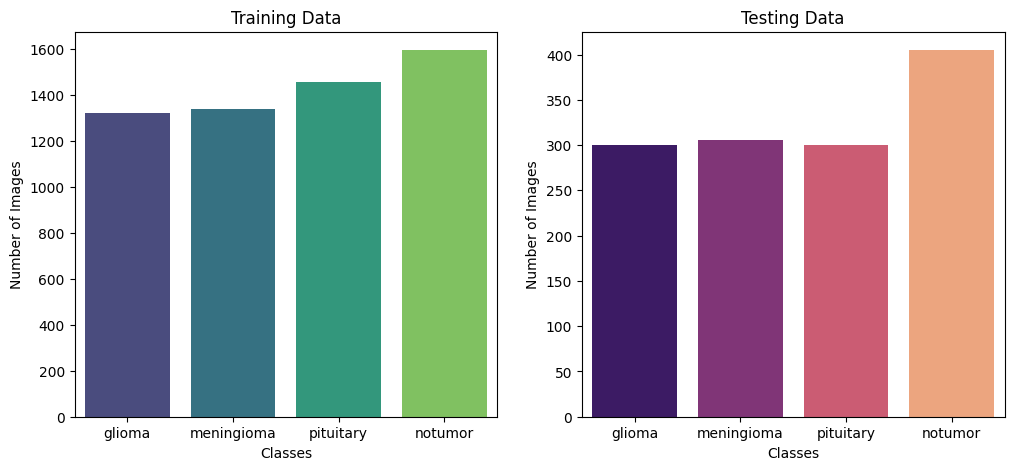

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.barplot(x= class_names, y=train_sizes, palette = "viridis",ax = axes[0], legend = False)
axes[0].set_title("Training Data")
axes[0].set_xlabel("Classes")
axes[0].set_ylabel("Number of Images")
# Plot 2
sns.barplot(x= class_names, y=test_sizes, palette = "magma",ax = axes[1], legend = False)
axes[1].set_title("Testing Data")
axes[1].set_xlabel("Classes")
axes[1].set_ylabel("Number of Images")
plt.show()

In [60]:
# Lets normalize the images
train_datagen = ImageDataGenerator(
    rescale=1./255
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [61]:
import os
import numpy as np
import random
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance

# Define image size
IMAGE_SIZE = 224

# Get class names from training directory
class_names = sorted(os.listdir(train_dir))  # Ensure label order is consistent

# Image Augmentation function
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))  # Random brightness
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))  # Random contrast
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    return image

# Load images and apply augmentation
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))  # Load and resize
        image = np.array(image)  # Convert to NumPy array
        image = augment_image(image)  # Apply augmentation
        images.append(image)
    return np.array(images)

# Encoding labels (convert label names to integers)
def encode_label(labels):
    encoded = [class_names.index(label) for label in labels]  # Use predefined class_names
    return np.array(encoded)

# Data generator for batching
def datagen(paths, labels, batch_size=12, epochs=1):
    for _ in range(epochs):
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i + batch_size]
            batch_images = open_images(batch_paths)  # Open and augment images
            batch_labels = labels[i:i + batch_size]
            batch_labels = encode_label(batch_labels)  # Encode labels
            yield batch_images, batch_labels  # Yield the batch


In [62]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Input

img_height, img_width = 224, 224  # Update based on your dataset
num_classes = 4  # Define number of classes manually

def build_model():
    inputs = Input(shape=(img_height, img_width, 3))

    x = Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2))(x)

    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation="relu")(x)

    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model


In [66]:
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height , img_width),
    batch_size = batch_size,
    class_mode = "categorical"
    )


test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height,img_width),
    batch_size =batch_size,
    class_mode ="categorical"
    )

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [67]:
from tensorflow.keras.optimizers import Adam

model = build_model()
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_generator, epochs=25, validation_data=test_generator)


Epoch 1/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 60s 533ms/step - accuracy: 0.6156 - loss: 1.0744 - val_accuracy: 0.2654 - val_loss: 3.7053
Epoch 2/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 38s 427ms/step - accuracy: 0.7860 - loss: 0.5278 - val_accuracy: 0.2372 - val_loss: 2.9597
Epoch 3/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 425ms/step - accuracy: 0.8447 - loss: 0.4116 - val_accuracy: 0.5645 - val_loss: 1.2357
Epoch 4/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 47s 496ms/step - accuracy: 0.8708 - loss: 0.3355 - val_accuracy: 0.7162 - val_loss: 0.8564
Epoch 5/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 54s 494ms/step - accuracy: 0.8901 - loss: 0.3148 - val_accuracy: 0.7963 - val_loss: 0.4815
Epoch 6/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 48s 533ms/step - accuracy: 0.9078 - loss: 0.2214 - val_accuracy: 0.8650 - val_loss: 0.3227
Epoch 7/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 52s 578ms/step - accuracy: 0.9206 - loss: 0.2058 - val_accuracy: 0.9153 - val_loss: 0.2061
Epoch 8/25
90/90 ━━━━━━━━━━━━━━━━━━━━ 44s 490ms/step - accuracy: 0.9301 - loss: 0.1842 - val_accu

In [69]:
# Get a batch of test data
x_test, y_test = next(test_generator)

# Ensure the batch size is consistent
x_test = x_test[:batch_size]
y_test = y_test[:batch_size]

# Make predictions
predictions = model.predict(x_test)

# Convert probabilities to class indices
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Evaluation metrics
print("Accuracy:", accuracy_score(true_classes, predicted_classes))
print("Classification Report:")
print(classification_report(true_classes, predicted_classes))
print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        19
           3       1.00      1.00      1.00        13

    accuracy                           1.00        64
   macro avg       1.00      1.00      1.00        64
weighted avg       1.00      1.00      1.00        64

Confusion Matrix:
[[13  0  0  0]
 [ 0 19  0  0]
 [ 0  0 19  0]
 [ 0  0  0 13]]


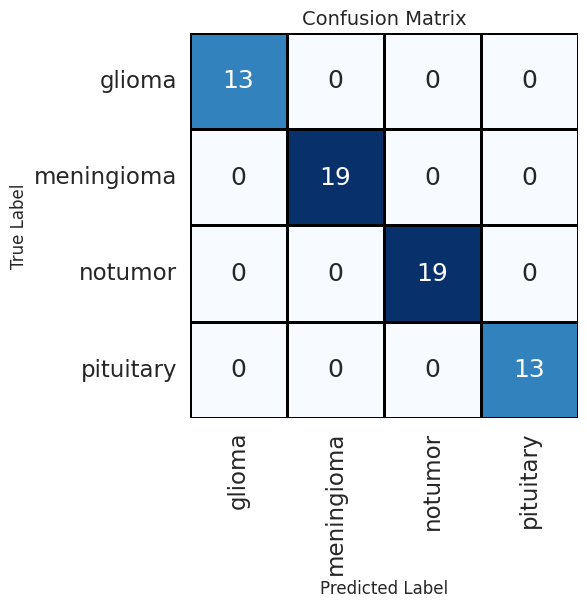

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set font scale for better readability
sns.set(font_scale=1.5)

def plot_conf_mat(true_labels, predicted_labels, class_names):
    """
    Plots a fancy Confusion Matrix using Seaborn's heatmap.
    """
    fig, ax = plt.subplots(figsize=(5, 5))  # Adjust size based on class count
    conf_mat = confusion_matrix(true_labels, predicted_labels)

    sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names, linewidths=1, linecolor='black')

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title("Confusion Matrix", fontsize=14)
    plt.show()

# Call function with class names
plot_conf_mat(true_classes, predicted_classes, class_names=test_generator.class_indices.keys())

In [72]:
pip install tensorflow numpy opencv-python matplotlib


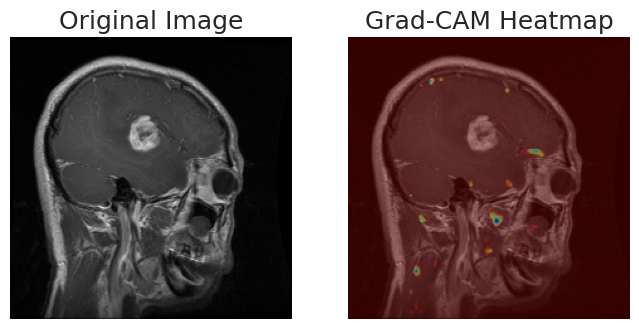

In [74]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

def get_grad_cam(model, img_array, layer_name):
    grad_model = Model(inputs=model.input, outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, np.argmax(predictions[0])]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = tf.squeeze(heatmap)
    heatmap = cv2.resize(heatmap.numpy(), (img_array.shape[2], img_array.shape[1]))
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

    return heatmap

def overlay_grad_cam(img_path, model, layer_name='conv2d_2'):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (img_width, img_height))
    img_array = np.expand_dims(img_resized, axis=0) / 255.0

    heatmap = get_grad_cam(model, img_array, layer_name)

    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img_resized, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_resized)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title("Grad-CAM Heatmap")
    plt.axis("off")
    plt.show()

# Run for a sample image
sample_image_path = test_generator.filepaths[0]  # Pick a random image from test set
overlay_grad_cam(sample_image_path, model, layer_name='conv2d_8')
